In [138]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
# knn ou random forest à tester

# I. Préparation des données d'entrainement

In [139]:
cost_csv = '../../data/silver/CostOfLiving_cleaned.csv'
df_cost = pd.read_csv(cost_csv)
# print(df_cost.columns)
print(df_cost.isna().sum())
print(df_cost.dtypes)

Pays     0
Item     0
Price    0
dtype: int64
Pays      object
Item      object
Price    float64
dtype: object


In [140]:
# Configuration du modèle
pollution_data = 'Pollution_index_Exp' # indice de pollution
rdn_state = 42 # seed pour la reproductibilité
test_part = 0.2 # % des données pour le test

In [141]:
pollution_csv = '../../data/silver/Pollution_global_cleaned.csv'
df_pollution = pd.read_csv(pollution_csv)
print(df_pollution.columns)
print(df_pollution.dtypes)
# We choose to use the flat index for now
df_pollution = df_pollution[['Country', pollution_data]]
print(df_pollution.columns)

Index(['Country', 'Pollution_index', 'Pollution_index_Exp'], dtype='object')
Country                 object
Pollution_index        float64
Pollution_index_Exp    float64
dtype: object
Index(['Country', 'Pollution_index_Exp'], dtype='object')


In [142]:
# Find countries present in Cost of Living but missing from Pollution data
missing_countries = set(df_cost['Pays']) - set(df_pollution['Country'])
print("Missing countries:", missing_countries)

# Find extra countries in Pollution not present in Cost of Living
extra_countries = set(df_pollution['Country']) - set(df_cost['Pays'])
print("Extra countries:", extra_countries)

Missing countries: {'Burkina_Faso', 'Comoros', 'Anguilla', 'Bonaire', 'Western_Sahara', 'Tonga', 'Wallis_And_Futuna', 'Montserrat', 'Saint_Vincent_And_The_Grenadines'}
Extra countries: set()


In [143]:
# Delete rows with missing target countries
df_cost = df_cost[~df_cost['Pays'].isin(missing_countries)]

In [144]:
# Map countries to numeric indicators
# country_mapping = {country: idx for idx, country in enumerate(df_cost['Pays'].unique())}
# df_cost['CountryID'] = df_cost['Pays'].map(country_mapping)

In [145]:
# Pivot the table to have all item prices on the same row for each country
# Pivot the data based on 'Pays' and 'Item', we are creating a column for each item with the price as the value
pivot_df = df_cost.pivot(index='Pays', columns='Item', values='Price')

In [146]:
# we adress countries with missing values
# First we drop the columns with too many missing values
pivot_df = pivot_df.drop(columns=['Bottle of Non-Alcoholic Wine (Mid-Range)', 'Buffalo Round (1kg) (or Equivalent Back Leg Red Meat)', 'Volkswagen Golf 1.4 90 KW Trendline (Or Equivalent New Car)'])

In [147]:
# Then we get rid of the rows remaining with missing values
pivot_df = pivot_df.dropna()
print(pivot_df.isna().sum().sum())

0


In [148]:
# Reset the index to make 'Pays' just a normal column again
pivot_df.reset_index(inplace=True)

In [149]:
# Add the 'CountryID' column to the pivoted DataFrame
# pivot_df['CountryID'] = pivot_df['Pays'].map(country_mapping)

In [150]:
# rename Polution country to Pays
df_pollution.rename(columns={"Country": "Pays"}, inplace=True)

In [151]:
# Merge both set (inner makes it useless to check for missing countries btw)
df_combined = pd.merge(pivot_df, df_pollution, on='Pays', how='inner')

In [152]:
# One Hot encoding des Pays !
df_combined = pd.get_dummies(df_combined, columns=["Pays"], drop_first=True)

In [153]:
df_combined[df_combined.columns[40:]].head(2)

,Price per Square Meter to Buy Apartment in City Centre,"Rice (white), (1kg)",Taxi 1hour Waiting (Normal Tariff),Taxi 1km (Normal Tariff),Taxi Start (Normal Tariff),Tennis Court Rent (1 Hour on Weekend),Tomato (1kg),Toyota Corolla Sedan 1.6l 97kW Comfort (Or Equivalent New Car),Water (0.33 liter bottle),Water (1.5 liter bottle),...,Pays_United_Arab_Emirates,Pays_United_Kingdom,Pays_United_States,Pays_Uruguay,Pays_Us_Virgin_Islands,Pays_Uzbekistan,Pays_Venezuela,Pays_Vietnam,Pays_Zambia,Pays_Zimbabwe
0,2676.23,2.06,20.59,1.03,7.21,20.59,4.12,22988.15,1.75,1.64,...,False,False,False,False,False,False,False,False,False,False
1,2426.32,1.96,15.05,3.14,3.14,24.71,1.53,29426.07,0.78,0.64,...,False,False,False,False,False,False,False,False,False,False


In [154]:
df_combined[pollution_data].head(10)

0     34.83
1    135.48
2    111.15
3     39.53
4    165.30
5     86.60
6    112.82
7     64.86
8     43.01
9     33.55
Name: Pollution_index_Exp, dtype: float64

In [155]:
df_combined.iloc[0]["Price per Square Meter to Buy Apartment in City Centre"]

2676.23

In [156]:
len(df_combined)

169

In [157]:
df_combined.dtypes

1 Pair of Jeans (Levis 501 Or Similar)              float64
1 Pair of Men Leather Business Shoes                float64
1 Pair of Nike Running Shoes (Mid-Range)            float64
1 Summer Dress in a Chain Store (Zara, H&M, ...)    float64
Apartment (1 bedroom) Outside of Centre             float64
                                                     ...   
Pays_Uzbekistan                                        bool
Pays_Venezuela                                         bool
Pays_Vietnam                                           bool
Pays_Zambia                                            bool
Pays_Zimbabwe                                          bool
Length: 219, dtype: object

# II. Configuration & training du modèle

In [158]:
X = df_combined.drop(columns=['Water (1.5 liter bottle)'], axis=1)  
y = df_combined['Water (1.5 liter bottle)']

In [159]:
# Normalize/scale data : If price columns are on a different scale than pollution index, scaling helps ?
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [160]:
# Split into training and test sets: 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_part, random_state=rdn_state)


In [161]:
## Train the model
## linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
## random forest model
# model = RandomForestRegressor()
# model.fit(X_train, y_train)
## naive bayes model
# model = GaussianNB()
# model.fit(X_train, y_train)

LinearRegression()

# III. Model Evaluation

In [162]:
# Predict on the test set
y_pred = model.predict(X_test)

In [163]:
# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

R²: 0.7547099855998856


In [164]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 0.11779006851798203


In [165]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.2530358964108538


# IV. Correction

In [166]:
print(X.shape)
print(y.shape)
print(X.head())
print(y.head())

(169, 218)
(169,)
   1 Pair of Jeans (Levis 501 Or Similar)  \
0                                   72.05   
1                                   58.05   
2                                   34.39   
3                                   99.50   
4                                   97.67   

   1 Pair of Men Leather Business Shoes  \
0                                 82.35   
1                                129.83   
2                                 67.21   
3                                128.67   
4                                254.73   

   1 Pair of Nike Running Shoes (Mid-Range)  \
0                                     85.78   
1                                     96.12   
2                                     64.63   
3                                    113.23   
4                                    129.43   

   1 Summer Dress in a Chain Store (Zara, H&M, ...)  \
0                                             29.16   
1                                             44.94   
2   

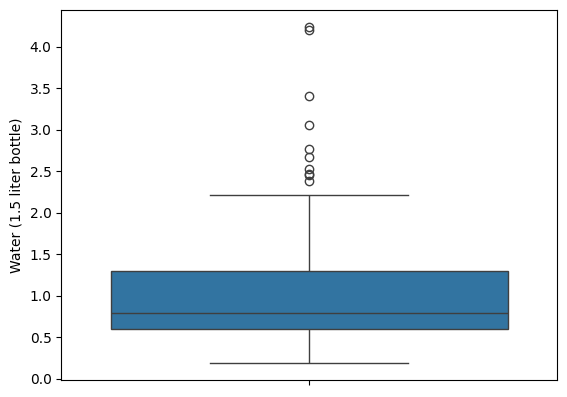

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.boxplot(y)
plt.show()

### Correlation

In [168]:
# Check for Correlation
correlation = df_combined.corr()
print(correlation[pollution_data][abs(correlation[pollution_data]) > 0.5])

Average Monthly Net Salary (After Tax)   -0.500480
Cinema, International Release, 1 Seat    -0.506265
Coke/Pepsi (0.33 liter bottle)           -0.563829
Meal, Inexpensive Restaurant             -0.518769
One-way Ticket (Local Transport)         -0.521945
Pollution_index_Exp                       1.000000
Name: Pollution_index_Exp, dtype: float64


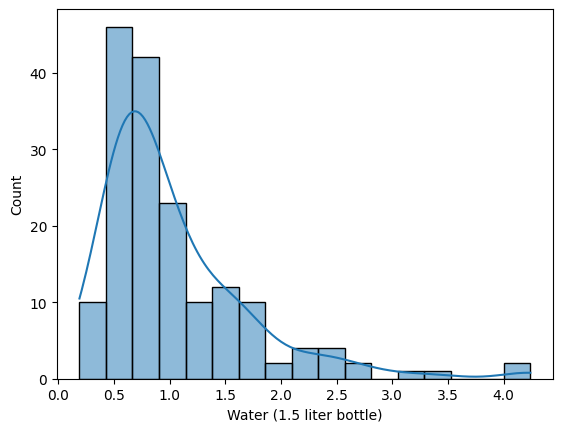

In [169]:
# Inspect the Target Variable (y)
sns.histplot(y, kde=True)
plt.show()

In [170]:
# Check feature scaling
print(X_scaled.mean(axis=0))  # Should be close to 0
print(X_scaled.std(axis=0))  # Should be close to 1

[ 1.68175795e-16  2.62774680e-17 -2.10219744e-17  3.04818629e-16
  1.15620859e-16 -4.46716957e-17 -1.62920302e-16  1.05109872e-17
  3.25840604e-16  7.35769105e-17 -1.10036897e-16  4.72994425e-17
  1.10365366e-16 -1.57664808e-17 -2.10219744e-16  1.47153821e-16
  4.20439489e-17 -6.30659233e-17 -9.98543785e-17  6.30659233e-17
 -4.72994425e-17  4.46716957e-17  6.83214169e-17  1.05109872e-16
 -9.45988849e-17  2.52263693e-16  1.57664808e-17 -3.15329616e-17
 -4.83505412e-16  2.10219744e-17  1.68175795e-16 -1.99708757e-16
 -1.05109872e-16 -1.05109872e-17  8.40878977e-17 -3.25840604e-16
 -3.46862578e-16  2.10219744e-16 -8.14601509e-17 -3.15329616e-17
  1.05109872e-17 -3.99417514e-16 -1.05109872e-17  2.20730732e-16
  3.15329616e-17  3.67884553e-16 -3.15329616e-17 -2.36497212e-17
 -1.83942276e-17  3.36351591e-16  1.57664808e-17  1.57664808e-17
  1.57664808e-17  1.57664808e-17  1.57664808e-17  1.57664808e-17
  1.57664808e-17  1.57664808e-17  1.57664808e-17  1.57664808e-17
  1.57664808e-17  1.57664